# Introduction
The Open University operate a mostly distance-based education platform, supported by a Virtual Learning Environment (VLE) to assist students with their courses. They have provided several datasets and a corresponding schematic with the aim of predicting which students on their courses will withdraw or fail their course.
Initially, the datasets will be examined for content, with the goal of merging all of the relevant data into a single dataset. This will involve deciding on which features to retain, to engineer into new columns, or to drop from the dataset. As both classification and regression are required, a target variable for withdrawn students will be used for classification, and a score-based variable will be used for regression. As failures are decided by the coursework and exam score (excluding extenuating circumstances), this score variable will be used as a proxy for examining failures.
Naturally, the extent of exloratory data analysis (EDA) actually executed vastly exceeds what is interesting, so some has been trimmed from this document for the sake of brevity.

# Importing and Merging Data

In [1]:
# Import standard packages, and set seaborn styling
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

## Student VLE data

In [2]:
svle = pd.read_csv("studentVle.csv")

In [3]:
svle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


In [4]:
svle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10655280 entries, 0 to 10655279
Data columns (total 6 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   code_module        object
 1   code_presentation  object
 2   id_student         int64 
 3   id_site            int64 
 4   date               int64 
 5   sum_click          int64 
dtypes: int64(4), object(2)
memory usage: 487.8+ MB


In [5]:
svle.describe()

,id_student,id_site,date,sum_click
count,1.065528e+07,1.065528e+07,1.065528e+07,1.065528e+07
mean,7.333336e+05,7.383234e+05,9.517400e+01,3.716946e+00
std,5.827060e+05,1.312196e+05,7.607130e+01,8.849047e+00
min,6.516000e+03,5.267210e+05,-2.500000e+01,1.000000e+00
25%,5.077430e+05,6.735190e+05,2.500000e+01,1.000000e+00
50%,5.882360e+05,7.300690e+05,8.600000e+01,2.000000e+00
75%,6.464840e+05,8.770300e+05,1.560000e+02,3.000000e+00
max,2.698588e+06,1.049562e+06,2.690000e+02,6.977000e+03


Having investigated the date column for empty rows and found none, the distribution of clicks by date is examined.

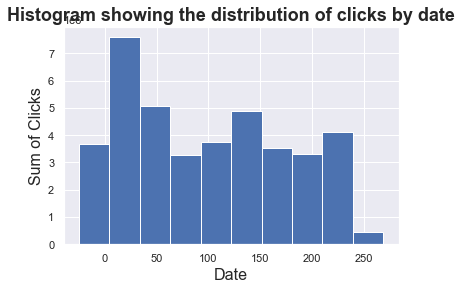

In [6]:
# Check date is not empty - not evident from describe due to size of dataset (output not shown)
# svle[np.isnan(svle['date'])]

# Import package to plot the graph
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(svle['date'], weights=svle['sum_click'], bins = 10)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Sum of Clicks', fontsize=16)
plt.title('Histogram showing the distribution of clicks by date', fontsize=18, fontweight = 'bold')
plt.show()

We know there are no empty date rows, and this distribution is fairly level apart from the initial spike once a course starts. It is therefore not immediately obvious how to split this data. However, from a behavioural perspective, it would make sense to split this into two categories of vle before/after the module start date - this makes 2 separate measures of how keen a student is to access learning materials both before and after starting a module.

In [7]:
# The new columns are created
svle['vle_before'] = np.where(svle['date']<0,svle['sum_click'],0)
svle['vle_after'] = np.where(svle['date']>=0,svle['sum_click'],0)
# The other columns are removed
svle = svle.drop(columns=['date','sum_click','id_site'])
# The remaining columns are grouped by student, module, and presentation
svle = svle.groupby(['id_student','code_presentation','code_module']).sum()
# Show the new structure
svle.head()

vle_before  vle_after
id_student code_presentation code_module                       
6516       2014J             AAA                 256       2535
8462       2013J             DDD                  81        565
           2014J             DDD                   0         10
11391      2013J             AAA                  98        836
23629      2013B             BBB                  14        147

In [8]:
svle.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 29228 entries, (6516, '2014J', 'AAA') to (2698588, '2014J', 'BBB')
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   vle_before  29228 non-null  int64
 1   vle_after   29228 non-null  int64
dtypes: int64(2)
memory usage: 774.8+ KB


## Student Information data

In [9]:
# The student info dataset is read in
sinfo = pd.read_csv("studentInfo.csv")
sinfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  int64 
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  int64 
 9   studied_credits       32593 non-null  int64 
 10  disability            32593 non-null  object
 11  final_result          32593 non-null  object
dtypes: int64(3), object(9)
memory usage: 3.0+ MB


In [10]:
sinfo.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [11]:
# Check the values for gender and disability
sinfo['gender'].unique()

array(['M', 'F'], dtype=object)

In [12]:
sinfo['disability'].unique()

array(['N', 'Y'], dtype=object)

In [13]:
# One-hot encode these variables - these need to be numeric to run the models
sinfo['gender_F'] = np.where(sinfo['gender']=='F',1,0)
sinfo['disability'] = np.where(sinfo['disability']=='Y',1,0)
sinfo = sinfo.drop(columns='gender')

In [14]:
# Check spread of missing values of imd_band across target groups
sinfo.groupby('final_result').count()

,code_module,code_presentation,id_student,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,gender_F
final_result,,,,,,,,,,,
Distinction,3024,3024,3024,3024,3024,2825,3024,3024,3024,3024,3024
Fail,7052,7052,7052,7052,7052,6907,7052,7052,7052,7052,7052
Pass,12361,12361,12361,12361,12361,11830,12361,12361,12361,12361,12361
Withdrawn,10156,10156,10156,10156,10156,9920,10156,10156,10156,10156,10156


Imd_band has missing values, but these do not appear to be informative across the 'final_result' classes. These can be imputed later and should not unduly influence the models.
To help with keeping track of the dataset operations, an arbitrary student is selected to follow through this process.

In [15]:
sinfo[sinfo['id_student'] == 8462]

,code_module,code_presentation,id_student,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,gender_F
14395,DDD,2013J,8462,London Region,HE Qualification,30-40%,55<=,0,90,0,Withdrawn,0
17560,DDD,2014J,8462,London Region,HE Qualification,30-40%,55<=,1,60,0,Withdrawn,0


In [16]:
# The datasets are merged into a new one, sdf
sdf = sinfo.merge(svle,on=['id_student','code_presentation','code_module'], how='left')

In [17]:
sdf[sdf['id_student'] == 8462]

,code_module,code_presentation,id_student,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,gender_F,vle_before,vle_after
14395,DDD,2013J,8462,London Region,HE Qualification,30-40%,55<=,0,90,0,Withdrawn,0,81.0,565.0
17560,DDD,2014J,8462,London Region,HE Qualification,30-40%,55<=,1,60,0,Withdrawn,0,0.0,10.0


In [18]:
sdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32593 entries, 0 to 32592
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   code_module           32593 non-null  object 
 1   code_presentation     32593 non-null  object 
 2   id_student            32593 non-null  int64  
 3   region                32593 non-null  object 
 4   highest_education     32593 non-null  object 
 5   imd_band              31482 non-null  object 
 6   age_band              32593 non-null  object 
 7   num_of_prev_attempts  32593 non-null  int64  
 8   studied_credits       32593 non-null  int64  
 9   disability            32593 non-null  int32  
 10  final_result          32593 non-null  object 
 11  gender_F              32593 non-null  int32  
 12  vle_before            29228 non-null  float64
 13  vle_after             29228 non-null  float64
dtypes: float64(2), int32(2), int64(3), object(7)
memory usage: 3.5+ MB


We notice here that student VLE data has absent rows, despite matching all of it with the student info dataset. This may suggest that those students had no interaction with the VLE at all, or it could suggest missing data - this will be discussed later.

In [19]:
# The two merged datasets are deleted for the sake of memory usage
del sinfo
del svle

## Student Registration data

In [20]:
# The student registration data is read in
sreg = pd.read_csv("studentRegistration.csv")
sreg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   code_module          32593 non-null  object 
 1   code_presentation    32593 non-null  object 
 2   id_student           32593 non-null  int64  
 3   date_registration    32548 non-null  float64
 4   date_unregistration  10072 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.2+ MB


We immediately notice that the date_registration has missing data - this makes no sense, as there would not be a record without a registration date. This data will need imputing later.

In [21]:
sreg.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


In [22]:
sreg.describe()

,id_student,date_registration,date_unregistration
count,3.259300e+04,32548.000000,10072.000000
mean,7.066877e+05,-69.411300,49.757645
std,5.491673e+05,49.260522,82.460890
min,3.733000e+03,-322.000000,-365.000000
25%,5.085730e+05,-100.000000,-2.000000
50%,5.903100e+05,-57.000000,27.000000
75%,6.444530e+05,-29.000000,109.000000
max,2.716795e+06,167.000000,444.000000


This is a very simple dataset - no further investigation is needed before merging this.

In [23]:
# The student record is again picked out
sreg[sreg['id_student']==8462]

,code_module,code_presentation,id_student,date_registration,date_unregistration
14395,DDD,2013J,8462,-137.0,119.0
17560,DDD,2014J,8462,-38.0,18.0


In [24]:
# The new dataset is merged to the existing one
sdf = sdf.merge(sreg,on=['id_student','code_presentation','code_module'], how='left')

In [25]:
sdf.head()

,code_module,code_presentation,id_student,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,gender_F,vle_before,vle_after,date_registration,date_unregistration
0,AAA,2013J,11391,East Anglian Region,HE Qualification,90-100%,55<=,0,240,0,Pass,0,98.0,836.0,-159.0,NaN
1,AAA,2013J,28400,Scotland,HE Qualification,20-30%,35-55,0,60,0,Pass,1,215.0,1220.0,-53.0,NaN
2,AAA,2013J,30268,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,1,Withdrawn,1,102.0,179.0,-92.0,12.0
3,AAA,2013J,31604,South East Region,A Level or Equivalent,50-60%,35-55,0,60,0,Pass,1,169.0,1989.0,-52.0,NaN
4,AAA,2013J,32885,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,0,Pass,1,295.0,739.0,-176.0,NaN


In [26]:
# The old dataset is removed from memory, and the new merged dataset shown
del sreg
sdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32593 entries, 0 to 32592
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   code_module           32593 non-null  object 
 1   code_presentation     32593 non-null  object 
 2   id_student            32593 non-null  int64  
 3   region                32593 non-null  object 
 4   highest_education     32593 non-null  object 
 5   imd_band              31482 non-null  object 
 6   age_band              32593 non-null  object 
 7   num_of_prev_attempts  32593 non-null  int64  
 8   studied_credits       32593 non-null  int64  
 9   disability            32593 non-null  int32  
 10  final_result          32593 non-null  object 
 11  gender_F              32593 non-null  int32  
 12  vle_before            29228 non-null  float64
 13  vle_after             29228 non-null  float64
 14  date_registration     32548 non-null  float64
 15  date_unregistration

## Courses data

In [27]:
# The courses dataset is read in
courses = pd.read_csv("courses.csv")
courses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   code_module                 22 non-null     object
 1   code_presentation           22 non-null     object
 2   module_presentation_length  22 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 656.0+ bytes


In [28]:
courses.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


Again, this is a very simple dataset. Here, the distribution of the presentation length column is investigated.

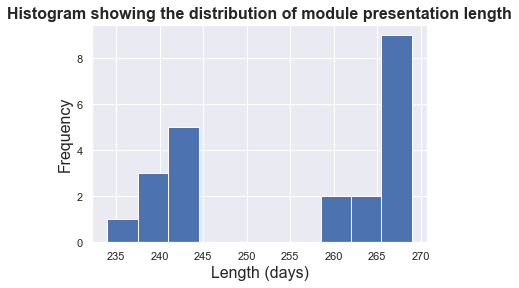

In [29]:
# Check the distribution of module presentation length
plt.hist(courses['module_presentation_length'])
plt.xlabel('Length (days)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title('Histogram showing the distribution of module presentation length', fontsize=16, fontweight = 'bold')
plt.show()

The module length distribution forms 2 clusters - modules will be assigned to a single new variable based on whether it is short or long, choosing the midpoint of 250 days as a cutoff.

In [30]:
# Create the new variable, merge the datasets, and delete the orginal dataset
courses['module_long'] = np.where(courses['module_presentation_length']>=250,1,0)
sdf = sdf.merge(courses,on=['code_presentation','code_module'], how='left')
del courses

In [31]:
sdf.head()

,code_module,code_presentation,id_student,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,gender_F,vle_before,vle_after,date_registration,date_unregistration,module_presentation_length,module_long
0,AAA,2013J,11391,East Anglian Region,HE Qualification,90-100%,55<=,0,240,0,Pass,0,98.0,836.0,-159.0,NaN,268,1
1,AAA,2013J,28400,Scotland,HE Qualification,20-30%,35-55,0,60,0,Pass,1,215.0,1220.0,-53.0,NaN,268,1
2,AAA,2013J,30268,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,1,Withdrawn,1,102.0,179.0,-92.0,12.0,268,1
3,AAA,2013J,31604,South East Region,A Level or Equivalent,50-60%,35-55,0,60,0,Pass,1,169.0,1989.0,-52.0,NaN,268,1
4,AAA,2013J,32885,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,0,Pass,1,295.0,739.0,-176.0,NaN,268,1


## Assessments data

In [32]:
# The assessments data is read in
assess = pd.read_csv("assessments.csv")
assess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        206 non-null    object 
 1   code_presentation  206 non-null    object 
 2   id_assessment      206 non-null    int64  
 3   assessment_type    206 non-null    object 
 4   date               195 non-null    float64
 5   weight             206 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.8+ KB


In [33]:
assess.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


Before the assessments data is merged to the general student dataframe (sdf), it may useful to examine the student assessment data first.

In [34]:
# Student assessment data is read in
stass = pd.read_csv("studentAssessment.csv")
stass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_assessment   173912 non-null  int64  
 1   id_student      173912 non-null  int64  
 2   date_submitted  173912 non-null  int64  
 3   is_banked       173912 non-null  int64  
 4   score           173739 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 6.6 MB


In [35]:
stass.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


It makes sense to merge the two assessment datasets first, before combining with the general dataset.

In [36]:
# Both assessment datasets are merged into one, stass
stass = stass.merge(assess,on='id_assessment', how='left')
stass.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173912 entries, 0 to 173911
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id_assessment      173912 non-null  int64  
 1   id_student         173912 non-null  int64  
 2   date_submitted     173912 non-null  int64  
 3   is_banked          173912 non-null  int64  
 4   score              173739 non-null  float64
 5   code_module        173912 non-null  object 
 6   code_presentation  173912 non-null  object 
 7   assessment_type    173912 non-null  object 
 8   date               171047 non-null  float64
 9   weight             173912 non-null  float64
dtypes: float64(3), int64(4), object(3)
memory usage: 14.6+ MB


In [37]:
# The original assessment dataset is deleted from memory
del assess
stass.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0
1,1752,28400,22,0,70.0,AAA,2013J,TMA,19.0,10.0
2,1752,31604,17,0,72.0,AAA,2013J,TMA,19.0,10.0
3,1752,32885,26,0,69.0,AAA,2013J,TMA,19.0,10.0
4,1752,38053,19,0,79.0,AAA,2013J,TMA,19.0,10.0


There are several rows with missing data in the 'date' field. This is examined to find that the rows with empty dates correspond to end of module exams only - this can be filled in later if necessary using module length data.

In [38]:
stass[ np.isnan(stass['date']) & (stass['assessment_type'] != 'Exam') ]

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight


The 2 date columns are reduced to 1, capturing the necessary information regarding how far in advance of a deadline the work was submitted.

In [39]:
# Create new column and drop the original two
stass['date_submit_advance'] = stass['date']-stass['date_submitted']
stass = stass.drop(columns = ['date','date_submitted'])
stass.head()

,id_assessment,id_student,is_banked,score,code_module,code_presentation,assessment_type,weight,date_submit_advance
0,1752,11391,0,78.0,AAA,2013J,TMA,10.0,1.0
1,1752,28400,0,70.0,AAA,2013J,TMA,10.0,-3.0
2,1752,31604,0,72.0,AAA,2013J,TMA,10.0,2.0
3,1752,32885,0,69.0,AAA,2013J,TMA,10.0,-7.0
4,1752,38053,0,79.0,AAA,2013J,TMA,10.0,0.0


In [40]:
# The assessment data can now be merged with the general dataset
sdf = sdf.merge(stass,on=['id_student','code_presentation','code_module'], how='left')

## VLE data

In [41]:
# The vle dataset is read in
vle = pd.read_csv("vle.csv")
print(vle.head())
print(vle.info())

   id_site code_module code_presentation activity_type  week_from  week_to
0   546943         AAA             2013J      resource        NaN      NaN
1   546712         AAA             2013J     oucontent        NaN      NaN
2   546998         AAA             2013J      resource        NaN      NaN
3   546888         AAA             2013J           url        NaN      NaN
4   547035         AAA             2013J      resource        NaN      NaN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6364 entries, 0 to 6363
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_site            6364 non-null   int64  
 1   code_module        6364 non-null   object 
 2   code_presentation  6364 non-null   object 
 3   activity_type      6364 non-null   object 
 4   week_from          1121 non-null   float64
 5   week_to            1121 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 298.4+

Looking at the schematic and description for vle.csv, this does not appear to contain worthwhile information, and looking at the data, there is too much missing data here to be useful. At this stage, a decision is made to exclude vle.csv from the dataset.

In [42]:
# The vle dataset is removed from memory
del vle
# All datasets (except vle) is now merged into sdf
sdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180662 entries, 0 to 180661
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   code_module                 180662 non-null  object 
 1   code_presentation           180662 non-null  object 
 2   id_student                  180662 non-null  int64  
 3   region                      180662 non-null  object 
 4   highest_education           180662 non-null  object 
 5   imd_band                    172852 non-null  object 
 6   age_band                    180662 non-null  object 
 7   num_of_prev_attempts        180662 non-null  int64  
 8   studied_credits             180662 non-null  int64  
 9   disability                  180662 non-null  int32  
 10  final_result                180662 non-null  object 
 11  gender_F                    180662 non-null  int32  
 12  vle_before                  177179 non-null  float64
 13  vle_after     

# Feature Engineering and Dataset Reduction
Whilst some feature engineering took place as the datasets were merged, now that there is one single dataset to work with, further feature engineering can take place.

In [43]:
# Display all columns
pd.set_option('max_columns', None)
sdf.head()

,code_module,code_presentation,id_student,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,gender_F,vle_before,vle_after,date_registration,date_unregistration,module_presentation_length,module_long,id_assessment,is_banked,score,assessment_type,weight,date_submit_advance
0,AAA,2013J,11391,East Anglian Region,HE Qualification,90-100%,55<=,0,240,0,Pass,0,98.0,836.0,-159.0,NaN,268,1,1752.0,0.0,78.0,TMA,10.0,1.0
1,AAA,2013J,11391,East Anglian Region,HE Qualification,90-100%,55<=,0,240,0,Pass,0,98.0,836.0,-159.0,NaN,268,1,1753.0,0.0,85.0,TMA,20.0,1.0
2,AAA,2013J,11391,East Anglian Region,HE Qualification,90-100%,55<=,0,240,0,Pass,0,98.0,836.0,-159.0,NaN,268,1,1754.0,0.0,80.0,TMA,20.0,2.0
3,AAA,2013J,11391,East Anglian Region,HE Qualification,90-100%,55<=,0,240,0,Pass,0,98.0,836.0,-159.0,NaN,268,1,1755.0,0.0,85.0,TMA,20.0,2.0
4,AAA,2013J,11391,East Anglian Region,HE Qualification,90-100%,55<=,0,240,0,Pass,0,98.0,836.0,-159.0,NaN,268,1,1756.0,0.0,82.0,TMA,30.0,3.0


In [44]:
# Student 8462 is again picked out, to gain a better understanding of the dataset as is
sdf[sdf['id_student']==8462]

,code_module,code_presentation,id_student,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,gender_F,vle_before,vle_after,date_registration,date_unregistration,module_presentation_length,module_long,id_assessment,is_banked,score,assessment_type,weight,date_submit_advance
78629,DDD,2013J,8462,London Region,HE Qualification,30-40%,55<=,0,90,0,Withdrawn,0,81.0,565.0,-137.0,119.0,261,1,25348.0,0.0,93.0,TMA,10.0,-4.0
78630,DDD,2013J,8462,London Region,HE Qualification,30-40%,55<=,0,90,0,Withdrawn,0,81.0,565.0,-137.0,119.0,261,1,25349.0,0.0,83.0,TMA,12.5,2.0
78631,DDD,2013J,8462,London Region,HE Qualification,30-40%,55<=,0,90,0,Withdrawn,0,81.0,565.0,-137.0,119.0,261,1,25350.0,0.0,87.0,TMA,17.5,3.0
91821,DDD,2014J,8462,London Region,HE Qualification,30-40%,55<=,1,60,0,Withdrawn,0,0.0,10.0,-38.0,18.0,262,1,25362.0,1.0,93.0,TMA,5.0,21.0
91822,DDD,2014J,8462,London Region,HE Qualification,30-40%,55<=,1,60,0,Withdrawn,0,0.0,10.0,-38.0,18.0,262,1,25363.0,1.0,83.0,TMA,10.0,42.0
91823,DDD,2014J,8462,London Region,HE Qualification,30-40%,55<=,1,60,0,Withdrawn,0,0.0,10.0,-38.0,18.0,262,1,25364.0,1.0,83.0,TMA,10.0,63.0
91824,DDD,2014J,8462,London Region,HE Qualification,30-40%,55<=,1,60,0,Withdrawn,0,0.0,10.0,-38.0,18.0,262,1,25365.0,1.0,87.0,TMA,25.0,112.0


We now have a combined dataset with multiple entries per student, due to multiple assessments and multiple sittings of a module. As we are looking to predict a student withdrawing or failing for any given attempt at a module, it would be useful to get a single row of data per student per module.

The exam result is separated into its own column, but first the weighting needs to be checked. This is becuase we want to look at students who fail or withdraw. An average score <40 over the coursework and exam counts as a fail, so these need to be considered separately.

In [45]:
# Look at exam weightings
sdf[sdf['assessment_type']=='Exam']['weight'].describe()

count    4959.0
mean      100.0
std         0.0
min       100.0
25%       100.0
50%       100.0
75%       100.0
max       100.0
Name: weight, dtype: float64

This shows us that where exams are used, they are all weighted as 100% in the data

In [46]:
# The exam scores are extracted from the dataset
exam_score = sdf[sdf['assessment_type']=='Exam'][['code_module','code_presentation','id_student','score']]
exam_score.rename(columns = {'score':'exam_score'}, inplace = True)
exam_score
#exam_score['code_module'].unique()

,code_module,code_presentation,id_student,exam_score
48066,CCC,2014B,29764,94.0
48075,CCC,2014B,29820,76.0
48083,CCC,2014B,40604,66.0
48092,CCC,2014B,42638,50.0
48104,CCC,2014B,46605,98.0
...,...,...,...,...
100172,DDD,2014J,2677210,71.0
100179,DDD,2014J,2678380,64.0
100192,DDD,2014J,2684043,69.0
100199,DDD,2014J,2685863,49.0


In [47]:
# The exams scores are merged back to the dataset as a new column
sdf = sdf.merge(exam_score,on=['code_presentation','code_module','id_student'], how='left')
sdf = sdf[sdf['assessment_type'] != 'Exam']
sdf.head()

,code_module,code_presentation,id_student,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,gender_F,vle_before,vle_after,date_registration,date_unregistration,module_presentation_length,module_long,id_assessment,is_banked,score,assessment_type,weight,date_submit_advance,exam_score
0,AAA,2013J,11391,East Anglian Region,HE Qualification,90-100%,55<=,0,240,0,Pass,0,98.0,836.0,-159.0,NaN,268,1,1752.0,0.0,78.0,TMA,10.0,1.0,NaN
1,AAA,2013J,11391,East Anglian Region,HE Qualification,90-100%,55<=,0,240,0,Pass,0,98.0,836.0,-159.0,NaN,268,1,1753.0,0.0,85.0,TMA,20.0,1.0,NaN
2,AAA,2013J,11391,East Anglian Region,HE Qualification,90-100%,55<=,0,240,0,Pass,0,98.0,836.0,-159.0,NaN,268,1,1754.0,0.0,80.0,TMA,20.0,2.0,NaN
3,AAA,2013J,11391,East Anglian Region,HE Qualification,90-100%,55<=,0,240,0,Pass,0,98.0,836.0,-159.0,NaN,268,1,1755.0,0.0,85.0,TMA,20.0,2.0,NaN
4,AAA,2013J,11391,East Anglian Region,HE Qualification,90-100%,55<=,0,240,0,Pass,0,98.0,836.0,-159.0,NaN,268,1,1756.0,0.0,82.0,TMA,30.0,3.0,NaN


We need to find the weighted average of scores for the coursework. It is not sufficient to do this in a simple weighted average aggregate function, as those students who have withdrawn may not have completed all coursework, so their weights will not add up to 100. One option to avoid the risk of scoring out of 100 and artificially deflating the scores of Withdrawn students would be to write a bespoke function to run within the aggregator. However, it is much simpler to run calculations on the data and add/remove calculation columns as appropriate to reach weighted averages for where the course has been completed and where the course has not been completed.

Three modules were identified as using some zero-weighted coursework, i.e. coursework that does not count towards the final mark. Module GGG has no coursework that counts towards the final grade. This type of coursework may be treated differently by students and thus provide a different type of data. The 'counted' coursework and 'uncounted' coursework scores will therefore be split into different variables accordingly.
Additionally, where a student withdraws, the weighting of their scores should be by the amount of coursework they completed before withdrawing - this will not add up to 100, so will need to be calculated separately based on the individual completed weightings per student. The two 'counted' columns will therefore be distinguished by 'counted score weighted', based on the amount of coursework that was completed, and 'counted score 100' where the score is weighted out of 100 as if the student submitted all coursework. 'Counted score 100' will therefore typically be a lower value for students that withdraw.

In [48]:
# Identify any modules using zero-weighted coursework.
sdf[sdf['weight'] == 0]['code_module'].unique()
# Module GGG has no coursework that counts towards the final grade.
sdf[sdf['code_module'] == 'GGG']['weight'].unique()

# Split off weights, and use these to generate weighted score columns.
weights = sdf.groupby(['code_module','code_presentation','id_student'], as_index=True).agg(total_cw_weight = ('weight','sum'))
sdf = sdf.merge(weights,on=['code_presentation','code_module','id_student'], how='left')
# Use a float64 number type to output NaN when dividing by zero rather than an error
sdf['counted_score_weighted'] = np.float64(sdf['score'] * sdf['weight'])/sdf['total_cw_weight']
# Counted score weighted is now set as the weighted proportion of the total coursework mark achieved
sdf['counted_score_w100'] = sdf['score'] * sdf['weight']/100
# Counted score 100 gives the weighted proportion of total coursework out of 100
sdf['uncounted_score'] = np.where((sdf['weight'] == 0) | np.isnan(sdf['weight']), sdf['score'], float("NaN"))

sdf.head()

,code_module,code_presentation,id_student,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,gender_F,vle_before,vle_after,date_registration,date_unregistration,module_presentation_length,module_long,id_assessment,is_banked,score,assessment_type,weight,date_submit_advance,exam_score,total_cw_weight,counted_score_weighted,counted_score_w100,uncounted_score
0,AAA,2013J,11391,East Anglian Region,HE Qualification,90-100%,55<=,0,240,0,Pass,0,98.0,836.0,-159.0,NaN,268,1,1752.0,0.0,78.0,TMA,10.0,1.0,NaN,100.0,7.8,7.8,NaN
1,AAA,2013J,11391,East Anglian Region,HE Qualification,90-100%,55<=,0,240,0,Pass,0,98.0,836.0,-159.0,NaN,268,1,1753.0,0.0,85.0,TMA,20.0,1.0,NaN,100.0,17.0,17.0,NaN
2,AAA,2013J,11391,East Anglian Region,HE Qualification,90-100%,55<=,0,240,0,Pass,0,98.0,836.0,-159.0,NaN,268,1,1754.0,0.0,80.0,TMA,20.0,2.0,NaN,100.0,16.0,16.0,NaN
3,AAA,2013J,11391,East Anglian Region,HE Qualification,90-100%,55<=,0,240,0,Pass,0,98.0,836.0,-159.0,NaN,268,1,1755.0,0.0,85.0,TMA,20.0,2.0,NaN,100.0,17.0,17.0,NaN
4,AAA,2013J,11391,East Anglian Region,HE Qualification,90-100%,55<=,0,240,0,Pass,0,98.0,836.0,-159.0,NaN,268,1,1756.0,0.0,82.0,TMA,30.0,3.0,NaN,100.0,24.6,24.6,NaN


In [49]:
# Check if any entries have no scores
sdf[(np.where(np.isnan(sdf['score']), 1, 0) == 1) & (sdf['final_result'] == 'Pass') ].head()

,code_module,code_presentation,id_student,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,gender_F,vle_before,vle_after,date_registration,date_unregistration,module_presentation_length,module_long,id_assessment,is_banked,score,assessment_type,weight,date_submit_advance,exam_score,total_cw_weight,counted_score_weighted,counted_score_w100,uncounted_score
2790,AAA,2014J,1336190,London Region,HE Qualification,80-90%,55<=,0,60,0,Pass,0,86.0,935.0,-23.0,NaN,269,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
7225,BBB,2013B,502717,Wales,Lower Than A Level,80-90%,0-35,1,240,0,Pass,1,30.0,1911.0,-21.0,NaN,240,0,14989.0,0.0,NaN,TMA,18.0,-29.0,NaN,81.0,NaN,NaN,NaN
7823,BBB,2013B,515497,London Region,A Level or Equivalent,0-10%,0-35,0,120,0,Pass,1,15.0,146.0,-24.0,NaN,240,0,14989.0,0.0,NaN,TMA,18.0,-32.0,NaN,97.0,NaN,NaN,NaN
16490,BBB,2013J,342685,Scotland,A Level or Equivalent,30-40%,0-35,0,60,1,Pass,1,16.0,767.0,-32.0,NaN,268,1,14998.0,0.0,NaN,TMA,18.0,-36.0,NaN,99.0,NaN,NaN,NaN
16554,BBB,2013J,352688,South Region,A Level or Equivalent,70-80%,0-35,0,210,0,Pass,1,67.0,416.0,-54.0,NaN,268,1,15001.0,0.0,NaN,TMA,18.0,-1.0,NaN,100.0,NaN,NaN,NaN


We see that there are ~7000 entries with no scores - some who have failed (through non-submission?) or withdrawn, but some have also passed (with no exam or counted score), possibly suggesting missing or corrupted data.

This dataset needs aggregating to get to one row representing one student per module per module presentation. The aggregate function accepts a dictionary that will define how to aggregate over each field.
This allows us to drop unnecessary fields also:
- Date of unregistration is not an interesting input - we just need to know whether they unregistered (i.e. withdrew), not when.
- ID of assessment is not necessary to keep in the data as it provides no quantitative information.
- The Banked status of assessments are not being distinguished in the dataset as this is an unnecessary complication - each attempt at a module is considered separately, and the fact that this may be an additional attempt at a module is already captured by the 'number of previous attempts' column.
- Score has been converted to new columns as above so is no longer needed.
- Assessment type seems arbitrary, other than the 'Exam' type, which has already been separated out.
- Weighting was used to find a weighted average score, but does not need to be maintained in the final dataset.

In [50]:
# Initialise a dictionary for the aggregate function
aggDict = {}
# Iterate through columns, calculating on each as appropriate
for col in sdf.columns:
    if col in ['date_unregistration','id_assessment','is_banked','score','assessment_type','weight','total_cw_weight']:
        pass
    elif col in ['counted_score_weighted','counted_score_w100','uncounted_score']:
        aggDict[col] = 'sum'
    elif col in ['date_submit_advance','module_presentation_length']:
        aggDict[col] = 'mean'
    else:
        aggDict[col] = 'first'
aggDict

{'code_module': 'first',
 'code_presentation': 'first',
 'id_student': 'first',
 'region': 'first',
 'highest_education': 'first',
 'imd_band': 'first',
 'age_band': 'first',
 'num_of_prev_attempts': 'first',
 'studied_credits': 'first',
 'disability': 'first',
 'final_result': 'first',
 'gender_F': 'first',
 'vle_before': 'first',
 'vle_after': 'first',
 'date_registration': 'first',
 'module_presentation_length': 'mean',
 'module_long': 'first',
 'date_submit_advance': 'mean',
 'exam_score': 'first',
 'counted_score_weighted': 'sum',
 'counted_score_w100': 'sum',
 'uncounted_score': 'sum'}

In [51]:
# The data is aggregated and the index reset
sdf = sdf.groupby(['code_module','code_presentation','id_student'], as_index=True).agg(aggDict)
sdf.reset_index(drop=True, inplace=True)

In [52]:
sdf.head()
sdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32589 entries, 0 to 32588
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   code_module                 32589 non-null  object 
 1   code_presentation           32589 non-null  object 
 2   id_student                  32589 non-null  int64  
 3   region                      32589 non-null  object 
 4   highest_education           32589 non-null  object 
 5   imd_band                    31478 non-null  object 
 6   age_band                    32589 non-null  object 
 7   num_of_prev_attempts        32589 non-null  int64  
 8   studied_credits             32589 non-null  int64  
 9   disability                  32589 non-null  int32  
 10  final_result                32589 non-null  object 
 11  gender_F                    32589 non-null  int32  
 12  vle_before                  29225 non-null  float64
 13  vle_after                   292

# Cleaning the Dataset
Now that there is one student per module per presentation, we need to create a new score column for average of 'exam score' and 'counted score w100' - if this is >=40, the student passes. It is worth noting that in the dataset, some students with scores <40 still pass - this is presumably due to extenuating circumstances or errors in data - this is impossible to predict for using the data provided. Instead, we assume the Open University's 40% passmark is consistent and therefore use regression to predict marks to determine pass/fail. This 'av_score' will be the target for regression (predicting fail via average score).
The counted_score_weighted will be an independent variable for the classifier only, as it will be highly correlated with the av_score, but may be useful in predicting withdrawals. A new column is made for one-hot encoding withdrawals as the target variable for classification.

In [53]:
# Create target variable for regression based on average exam and counted coursework score and remove the original columns
sdf['av_cscore'] = np.nanmean([sdf['exam_score'],sdf['counted_score_w100']], axis=0)
sdf = sdf.drop(columns=['counted_score_w100','exam_score'])

#  Create target variable for classification, 'Withdrawn'
sdf['withdrawn'] = np.where(sdf['final_result'] == 'Withdrawn', 1, 0)
sdf.head()

,code_module,code_presentation,id_student,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,gender_F,vle_before,vle_after,date_registration,module_presentation_length,module_long,date_submit_advance,counted_score_weighted,uncounted_score,av_cscore,withdrawn
0,AAA,2013J,11391,East Anglian Region,HE Qualification,90-100%,55<=,0,240,0,Pass,0,98.0,836.0,-159.0,268,1,1.8,82.4,0.0,82.4,0
1,AAA,2013J,28400,Scotland,HE Qualification,20-30%,35-55,0,60,0,Pass,1,215.0,1220.0,-53.0,268,1,0.0,65.4,0.0,65.4,0
2,AAA,2013J,30268,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,1,Withdrawn,1,102.0,179.0,-92.0,268,1,NaN,0.0,0.0,0.0,1
3,AAA,2013J,31604,South East Region,A Level or Equivalent,50-60%,35-55,0,60,0,Pass,1,169.0,1989.0,-52.0,268,1,2.0,76.3,0.0,76.3,0
4,AAA,2013J,32885,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,0,Pass,1,295.0,739.0,-176.0,268,1,-11.4,55.0,0.0,55.0,0


In [54]:
# Student 8462 is picked out again to see the dataset progress
sdf[sdf['id_student']==8462]

,code_module,code_presentation,id_student,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,gender_F,vle_before,vle_after,date_registration,module_presentation_length,module_long,date_submit_advance,counted_score_weighted,uncounted_score,av_cscore,withdrawn
14395,DDD,2013J,8462,London Region,HE Qualification,30-40%,55<=,0,90,0,Withdrawn,0,81.0,565.0,-137.0,261,1,0.333333,87.25,0.0,34.9,1
17557,DDD,2014J,8462,London Region,HE Qualification,30-40%,55<=,1,60,0,Withdrawn,0,0.0,10.0,-38.0,262,1,59.500000,86.00,0.0,43.0,1


The code presentation column will be dropped - this is because, whilst prediction models can use this variable, it is arbitrary to predict using date variables in the past without a time series approach. Whilst using this variable here may help the model in prediction when this dataset is split, this model would not be able to adapt to any future presentations of modules as these would have a 'code_presentation' outside of this dataset. This would make the module useless in practise.
The 'id_student' column will also be dropped - this is a decision made that each attempt at a module is a separate event, and we are aiming to predict whether on any given attempt at a module the student will fail or withdraw. This is why we are not grouping by student id, and this column can now be dropped.

In [55]:
sdf = sdf.drop(columns=['code_presentation','id_student'])
sdf.head()

,code_module,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,gender_F,vle_before,vle_after,date_registration,module_presentation_length,module_long,date_submit_advance,counted_score_weighted,uncounted_score,av_cscore,withdrawn
0,AAA,East Anglian Region,HE Qualification,90-100%,55<=,0,240,0,Pass,0,98.0,836.0,-159.0,268,1,1.8,82.4,0.0,82.4,0
1,AAA,Scotland,HE Qualification,20-30%,35-55,0,60,0,Pass,1,215.0,1220.0,-53.0,268,1,0.0,65.4,0.0,65.4,0
2,AAA,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,1,Withdrawn,1,102.0,179.0,-92.0,268,1,NaN,0.0,0.0,0.0,1
3,AAA,South East Region,A Level or Equivalent,50-60%,35-55,0,60,0,Pass,1,169.0,1989.0,-52.0,268,1,2.0,76.3,0.0,76.3,0
4,AAA,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,0,Pass,1,295.0,739.0,-176.0,268,1,-11.4,55.0,0.0,55.0,0


The difference between module code and module presentation length was examined, as these columns may be recording the same information in different ways. However this was not the case, as the module length varies across all modules.
Whilst there is not a large spread in presentation length, the module length does not appear to be constant with regards to module code. However, module length has been encoded as short and long, so the original column will be dropped at this point.

In [56]:
for modCode in sdf['code_module'].unique():
    print(modCode)
    print(sdf[sdf['code_module'] == modCode]['module_presentation_length'].unique())
sdf = sdf.drop(columns='module_presentation_length')

AAA
[268 269]
BBB
[240 268 234 262]
CCC
[241 269]
DDD
[240 261 241 262]
EEE
[268 241 269]
FFF
[240 268 241 269]
GGG
[261 241 269]


There are several categorical variables in our dataset. For the sake of machine learning algorithms, these need to be numerically encoded. To give a better idea of what the dataset contains, value counts are made for each categorical column

In [57]:
# Print column names
#for col in sdf.columns:
#    print("'{}'".format(col), end=", ", flush=True)

# Print categorical column value counts
catCol = ['code_module', 'region', 'highest_education', 'imd_band', 'age_band']
for col in catCol:
    print(sdf[col].value_counts())
    print("\n")

BBB    7909
FFF    7762
DDD    6268
CCC    4434
EEE    2934
GGG    2534
AAA     748
Name: code_module, dtype: int64


Scotland                3446
East Anglian Region     3340
London Region           3214
South Region            3091
North Western Region    2906
West Midlands Region    2582
South West Region       2436
East Midlands Region    2365
South East Region       2111
Wales                   2085
Yorkshire Region        2006
North Region            1823
Ireland                 1184
Name: region, dtype: int64


A Level or Equivalent          14043
Lower Than A Level             13157
HE Qualification                4729
No Formal quals                  347
Post Graduate Qualification      313
Name: highest_education, dtype: int64


20-30%     3654
30-40%     3539
10-20      3516
0-10%      3310
40-50%     3254
50-60%     3124
60-70%     2905
70-80%     2878
80-90%     2762
90-100%    2536
Name: imd_band, dtype: int64


0-35     22941
35-55     9432
55<=       216
Name: age_band,

There are no excessively small categories in any of the categorical data columns. The code_module and region columns contain nominal data, so will be one-hot encoded to new columns. The other 3 columns contain ordinal data, so each will have their categories labelled in a new single numeric column.

The nominal categories are multicolinear, and one column could be dropped from each set and retain the same information. However, this is only an issue where a non-regularised linear model is used - where regularisation or other model types are utilised, it is fine to maintain multicolinear variables in the dataset, and removing one category can affect the prediction depending on which is removed. All categories are therefore encoded (inmachineswetrust.com/posts/drop-first-columns).

The ordinal category encoding could be executed with LabelEncoder, but there are not many categories and a replace method with explicit encoding allows later referral and potentially simpler modification of the encoding method.

In [58]:
# Define which categories are nominal
nomCat = ['code_module', 'region']
# Encode nominal categories
for cat in nomCat:
    catDummy = pd.get_dummies(sdf[cat], prefix=cat)
    sdf = catDummy.join(sdf)
sdf = sdf.drop(columns=nomCat)

# Define and encode ordinal categories
ordCat = {
  'highest_education': {
      'No Formal quals': 0,
      'Lower Than A Level': 1,
      'A Level or Equivalent': 2,
      'HE Qualification': 3,
      'Post Graduate Qualification': 4
  },
  'imd_band': {
      '0-10%': 0,
      '10-20': 1,
      '20-30%': 2,
      '30-40%': 3,
      '40-50%': 4,
      '50-60%': 5,
      '60-70%': 6,
      '70-80%': 7,
      '80-90%': 8,
      '90-100%': 9
  },
  'age_band': {
      '0-35': 0,
      '35-55': 1,
      '55<=': 2
  }
}
sdf.replace(ordCat, inplace=True)

Looking at the uncounted score variable, this is only available for ~27% of the data rows - this is impractical to work with and unlikely to be very informative as it is ungraded, so this column is dropped.

In [59]:
sdf['uncounted_score'].count() / len(sdf)

1.0

In [60]:
sdf = sdf.drop(columns='uncounted_score')
sdf.head()

,region_East Anglian Region,region_East Midlands Region,region_Ireland,region_London Region,region_North Region,region_North Western Region,region_Scotland,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region,code_module_AAA,code_module_BBB,code_module_CCC,code_module_DDD,code_module_EEE,code_module_FFF,code_module_GGG,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,gender_F,vle_before,vle_after,date_registration,module_long,date_submit_advance,counted_score_weighted,av_cscore,withdrawn
0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,3,9.0,2,0,240,0,Pass,0,98.0,836.0,-159.0,1,1.8,82.4,82.4,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,3,2.0,1,0,60,0,Pass,1,215.0,1220.0,-53.0,1,0.0,65.4,65.4,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,3.0,1,0,60,1,Withdrawn,1,102.0,179.0,-92.0,1,NaN,0.0,0.0,1
3,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,2,5.0,1,0,60,0,Pass,1,169.0,1989.0,-52.0,1,2.0,76.3,76.3,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,5.0,0,0,60,0,Pass,1,295.0,739.0,-176.0,1,-11.4,55.0,55.0,0


In [61]:
sdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32589 entries, 0 to 32588
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   region_East Anglian Region   32589 non-null  uint8  
 1   region_East Midlands Region  32589 non-null  uint8  
 2   region_Ireland               32589 non-null  uint8  
 3   region_London Region         32589 non-null  uint8  
 4   region_North Region          32589 non-null  uint8  
 5   region_North Western Region  32589 non-null  uint8  
 6   region_Scotland              32589 non-null  uint8  
 7   region_South East Region     32589 non-null  uint8  
 8   region_South Region          32589 non-null  uint8  
 9   region_South West Region     32589 non-null  uint8  
 10  region_Wales                 32589 non-null  uint8  
 11  region_West Midlands Region  32589 non-null  uint8  
 12  region_Yorkshire Region      32589 non-null  uint8  
 13  code_module_AAA 

Now that the dataset has a basic structure, we find there are several columns with missing data.
1. Roughly a quarter of the data has missing values in at least one column. We will need to impute values for imd_band, as there is clearly missing data here - every student must belong to an imd_band.
2. Similarly, we cannot assume the Student VLE dataset is complete, as vle_before and vle_after have the same missing values - these will be imputed also.
3. Date_registration must have a value, but is missing in 45 records. These records contain a lot of missing information, and appear to be mostly students that have withdrawn without submitting any work, possibly before the course has even started. As a tiny fraction of the dataset, these records will be removed going forward.
4. The date_submit_advance missing values correspond almost entirely to students who have Withdrawn or Failed. It would make sense to set this column to 0 for these records, indicating that at the hand-in date, no work was submitted. There are only 2 records in the dataset remaining where students have passed without submitting any work or exam. Either this data is missing also or these students were Passed based on extenuating circumstances - either way, they are anomalies, and will be removed from the dataset.

In [62]:
# Identify rows with missing data
sdf[sdf.isnull().any(axis=1) == False].shape
# Look at the rows missings values in the vle before and after columns
sdf[(sdf['vle_before'].isnull() == True) & (sdf['vle_after'].isnull() == True)].shape
# Look at rows with date_registration missing
sdf[sdf['date_registration'].isnull()]
# Remove rows with missing date of registration
sdf = sdf[sdf['date_registration'].isnull() == False]

# Identify date_submit_advance missing values corresponding to students who have Withdrawn or Failed.
sdf[(sdf['date_submit_advance'].isnull()) & (sdf['final_result'] != 'Fail') & (sdf['final_result'] != 'Withdrawn')]
# Set this column to 0 for these records, and drop the anomalies
a = sdf[(sdf['date_submit_advance'].isnull()) & (sdf['final_result'] != 'Fail') & (sdf['final_result'] != 'Withdrawn')]
sdf = sdf.drop(index = a.index)
sdf['date_submit_advance'] = np.where(sdf['date_submit_advance'].isnull(), 0, sdf['date_submit_advance'])
# The final result column can now be dropped from the dataset
sdf = sdf.drop(columns='final_result')
sdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32542 entries, 0 to 32588
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   region_East Anglian Region   32542 non-null  uint8  
 1   region_East Midlands Region  32542 non-null  uint8  
 2   region_Ireland               32542 non-null  uint8  
 3   region_London Region         32542 non-null  uint8  
 4   region_North Region          32542 non-null  uint8  
 5   region_North Western Region  32542 non-null  uint8  
 6   region_Scotland              32542 non-null  uint8  
 7   region_South East Region     32542 non-null  uint8  
 8   region_South Region          32542 non-null  uint8  
 9   region_South West Region     32542 non-null  uint8  
 10  region_Wales                 32542 non-null  uint8  
 11  region_West Midlands Region  32542 non-null  uint8  
 12  region_Yorkshire Region      32542 non-null  uint8  
 13  code_module_AAA 

# Splitting, Transforming, Imputing, Oversampling

Before any imputation is made for any remaining missing values, it is worth splitting the data into train and test sets. This allows us to see how adaptable any models will be to new data, even if they have missing values themselves. All operations to this point got the dataset in a workable format, but it must be split now to prevent any inference of the test set data on the training set data.
There are ultimately two targets being investigated using different methods as per the assignment:
- A regression approach will target 'av_cscore', to predict which students will fail (av_cscore <40)
- A classification approach will target 'withdrawn', to predict which students will withdraw (withdrawn = 1)
As such, the datasets used in each case will vary slightly, and these will be labelled r and c as appropriate.

The regression data set excludes all records where students have withdrawn. This is because we are predicting whether a student will fail, and students withdrawing from the module will skew these results downwards. In other words, we cannot say whether a student would have failed had they not withdrawn.
For regression, counted_score_weighted is excluded as a column as this will be very highly correlated to av_cscore (our target), particularly where students didn't withdraw - the only purpose of this column is to help with predicting withdrawals, i.e. not for this task.
For classification, the av_cscore is not used as counted_score_weighted gives a better impression of a student's marks before dropping out whilst also being relevant to students that didn't drop out - this is due to its weighting being only by the coursework that was completed prior to dropping out.

In [63]:
from sklearn.model_selection import train_test_split
# Create the regression dataset
regData = sdf[sdf['withdrawn']==0]
# Split the regression data
Xr_train, Xr_test, yr_train, yr_test = train_test_split(regData.iloc[:,0:32],regData.iloc[:,33], random_state = 618)
# Split the classification data
Xc_train, Xc_test, yc_train, yc_test = train_test_split(sdf.iloc[:,0:33],sdf.iloc[:,34], random_state = 618)

In [64]:
# View the training data
print(Xr_train.info())
print("\n")
print(Xc_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16818 entries, 21500 to 2078
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   region_East Anglian Region   16818 non-null  uint8  
 1   region_East Midlands Region  16818 non-null  uint8  
 2   region_Ireland               16818 non-null  uint8  
 3   region_London Region         16818 non-null  uint8  
 4   region_North Region          16818 non-null  uint8  
 5   region_North Western Region  16818 non-null  uint8  
 6   region_Scotland              16818 non-null  uint8  
 7   region_South East Region     16818 non-null  uint8  
 8   region_South Region          16818 non-null  uint8  
 9   region_South West Region     16818 non-null  uint8  
 10  region_Wales                 16818 non-null  uint8  
 11  region_West Midlands Region  16818 non-null  uint8  
 12  region_Yorkshire Region      16818 non-null  uint8  
 13  code_module_A

The 2 datasets for regression and classification are very similar, with an extra column (counted_score_weighted) present in the classification set, as well as more rows of data. Any methods to modify one dataset will therefore also be applied to the other where appropriate.
It is worth examining the data for correlations between variables, as these may need to be combined if correlated. 

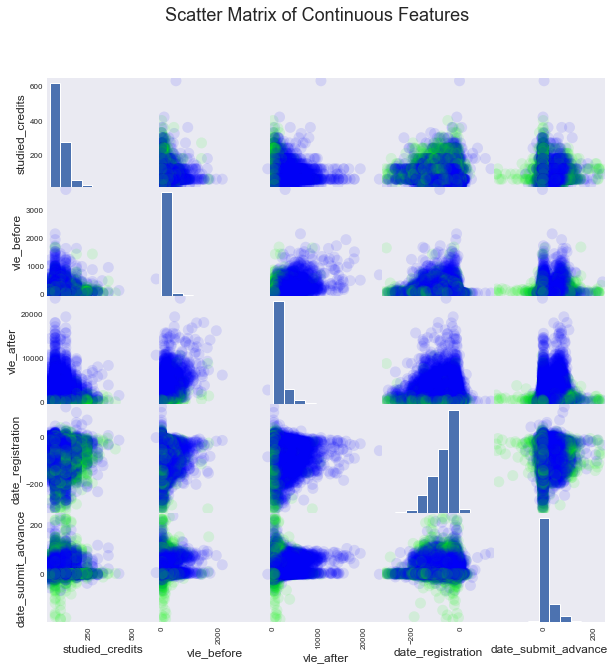

In [65]:
# Temporarily remove missing values from dataset to allow plotting of correlation matrix
Xrm = Xc_train[Xc_train.isnull().any(axis=1) == False]
yrm = yc_train.loc[Xrm.index,].values

plt.style.use('seaborn-dark')
_ = pd.plotting.scatter_matrix(Xrm.iloc[:, [24,27,28,29,31]], c=yrm, figsize = [10,10], s=120, marker = 'C', alpha = 0.1, cmap='brg')
_ = plt.suptitle('Scatter Matrix of Continuous Features', fontsize=18)
plt.show()

There is no obvious pairwise correlation evident with the continuous data shown, but there is some skew present in the histograms. Colouring by withdrawn status also allows visualisation of separation between the classes here, which is not particularly apparent. Correlations are further investigated with a heatmap (code adapted from towardsdatascience.com/data-transformation-e7b3b4268151).

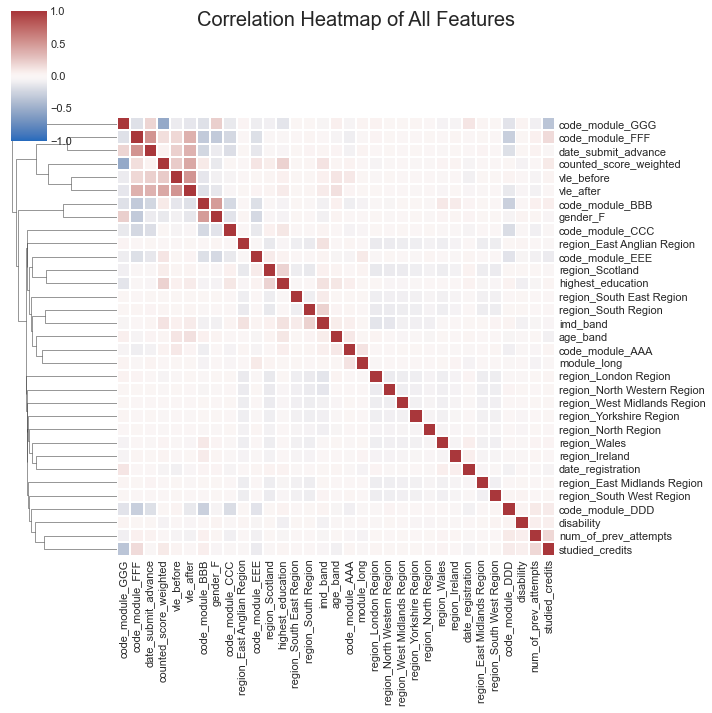

In [66]:
# Build heatmap from correlation matrix
corr_features = Xrm.corr()
a = sns.clustermap(corr_features, cmap='vlag', linewidth=1, vmin=-1, figsize=[10,10])
a.fig.suptitle('Correlation Heatmap of All Features', fontsize=20)
a.ax_col_dendrogram.set_visible(False)
plt.show()

There is some stronger correlation between some features, mostly with use of the virtual learning environment. Most notably, this correlates positively with the score achieved by students. The modelling will help to determine whether this persists as a noticeable predictor in regression.
It is beneficial for later modelling to normalise the data. This centres and scales each feature to have unit variance and mean of zero. This is useful to avoid the scale of a feature disproportionately influencing a model due its scale, which is a particular concern when using models like kNN where distance plays a key role.
As there is some skew present in the data, the PowerTransformer is used to both normalise and coerce the features to a Gaussian distribution - whilst this is not essential, doing so typically improves model performance where skew is present in the data. The yeo-johnson method is chosen as the dataset contains some negative data, making it unsuitable for the box-cox method. (https://scikit-learn.org/stable/modules/preprocessing.html#non-linear-transformation)

In [67]:
# Transform features data
from sklearn.preprocessing import PowerTransformer
transformer = PowerTransformer(method='yeo-johnson')
Xc_train_trans = transformer.fit_transform(Xc_train)
Xc_test_trans = transformer.fit_transform(Xc_test)
Xr_train_trans = transformer.fit_transform(Xr_train)
Xr_test_trans = transformer.fit_transform(Xr_test)

Note: This transformation has to be performed on the test set also to get to a similar scale - the transform function will not be identical to both the training and test sets, but with enough data in each and random sampling they should be similar. This is not performed prior to splitting to avoid the test data influencing the training data or vice versa.

There is an issue of missing values in the X datasets. We have no idea as to the actual values for imd_band or vle use, but we do know that rows with missing values make up <12.5% of the dataset.
kNN imputation is generally effective as an imputer, and has better adaption to a dataset than a simple central measurement imputer (https://machinelearningmastery.com/knn-imputation-for-missing-values-in-machine-learning/). For now, the imputer parameters will be set somewhat arbitrarily just to help with EDA, but this will be modified later.

In [68]:
# Impute values
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
Xc_train_imp = imputer.fit_transform(Xc_train_trans)
Xc_train_cols = Xc_train.columns
Xr_train_imp = imputer.fit_transform(Xr_train_trans)
Xr_train_cols = Xr_train.columns

Looking at the imputed dataset, we can see that there are no more missing values

In [69]:
Xc_train_imp = pd.DataFrame(Xc_train_imp)
Xc_train_imp.columns = Xc_train_cols
Xr_train_imp = pd.DataFrame(Xr_train_imp)
Xr_train_imp.columns = Xr_train_cols
Xc_train_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24406 entries, 0 to 24405
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   region_East Anglian Region   24406 non-null  float64
 1   region_East Midlands Region  24406 non-null  float64
 2   region_Ireland               24406 non-null  float64
 3   region_London Region         24406 non-null  float64
 4   region_North Region          24406 non-null  float64
 5   region_North Western Region  24406 non-null  float64
 6   region_Scotland              24406 non-null  float64
 7   region_South East Region     24406 non-null  float64
 8   region_South Region          24406 non-null  float64
 9   region_South West Region     24406 non-null  float64
 10  region_Wales                 24406 non-null  float64
 11  region_West Midlands Region  24406 non-null  float64
 12  region_Yorkshire Region      24406 non-null  float64
 13  code_module_AAA 

Looking at the target (positive) class for classification, we notice an imbalance of data.

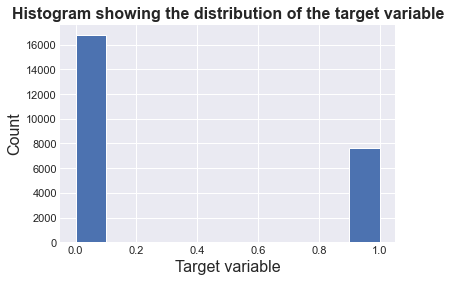

In [70]:
# Create target variable histogram
yc_train.hist()
plt.xlabel('Target variable', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title('Histogram showing the distribution of the target variable', fontsize=16, fontweight = 'bold')
plt.show()

Whilst this kind of target imbalance is not uncommon, this can later affect the performance metrics of prediction models, particularly where the minor class is also the positive class.
There are several options for dealing with this issue. Under-sampling would involve removing data of the major class until the classes balance. This would involve removing about 1/3 of our dataset, and as it is not very large here, this is not a good option. Oversampling would involve duplicating (resampling) data in the positive class. This is a good option here, but combining this with synthetic sampling would make this even more effective. This adds randomness into the over-sampled data to produce similar but not identical data for the minority class. The SMOTE method is used here to achieve this, giving 33540 rows from the original 24406.(https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)
Code adapted from https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33540 entries, 0 to 33539
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   region_East Anglian Region   33540 non-null  float64
 1   region_East Midlands Region  33540 non-null  float64
 2   region_Ireland               33540 non-null  float64
 3   region_London Region         33540 non-null  float64
 4   region_North Region          33540 non-null  float64
 5   region_North Western Region  33540 non-null  float64
 6   region_Scotland              33540 non-null  float64
 7   region_South East Region     33540 non-null  float64
 8   region_South Region          33540 non-null  float64
 9   region_South West Region     33540 non-null  float64
 10  region_Wales                 33540 non-null  float64
 11  region_West Midlands Region  33540 non-null  float64
 12  region_Yorkshire Region      33540 non-null  float64
 13  code_module_AAA 

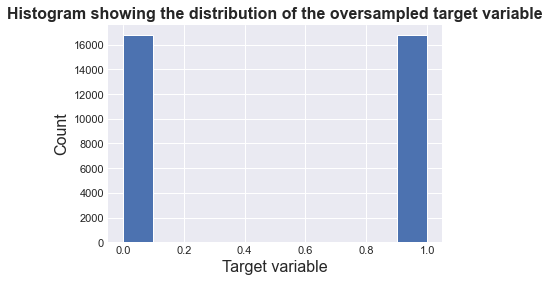

In [291]:
# Execute SMOTE and plot new target histogram
#!pip install imblearn
from imblearn.over_sampling import SMOTE
oversample = SMOTE(random_state = 314)
Xc_trainOS,yc_trainOS = oversample.fit_resample(Xc_train_imp,yc_train)
Xc_trainOS.info()
yc_trainOS.hist()
plt.xlabel('Target variable', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title('Histogram showing the distribution of the oversampled target variable', fontsize=16, fontweight = 'bold')
plt.show()

# Modelling with Pipelines
There is now a class-balanced version of the classification training dataset and both datasets are free of missing values. Several operations have been performed on the data since splitting, providing different variables to now work with in modelling. This process is summarised below:
- Regression set (predicting scores): traintestsplit - PowerTransformer - KNNImputer - Xr_train_imp & yr_train
- Classification set (predicting withdrawals): traintestsplit - PowerTransformer - KNNImputer - SMOTE - Xc_trainOS & yc_trainOS
These operations can be put into a pipeline to allow automation of hyperparameter tuning. As there are no parameters of the PowerTransformer that need tuning, the pipeline will commence after this step to avoid wasteful computation through repetition.

## Classification
### kNN
To demonstrate the process going forward and establish a baseline for modelling and assessment, a simple KNN prediction model is built for classification.
To avoid overfitting of the models to the training data when tuning hyperparameters, k-fold cross-validation is used. Here, a grid-based cross-validation approach is used, which tests all values of all hyperparameters specified to find the best model based on its recall score.

In [90]:
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

# Specify steps of pipeline
c_steps = [('impute', KNNImputer()),
           ('smote', SMOTE(random_state = 314)),
           ('knn', KNeighborsClassifier())]
# Construct the pipeline
c_pipe = Pipeline(c_steps)
# Decide ranges of parameters to use
parameters = {
    'impute__n_neighbors': np.arange(3,12),
    'knn__n_neighbors': np.arange(4,7)
}
# Set up cross-validation of the pipeline (5-fold chosen, and n_jobs allows parallel processing)
knn_cv = GridSearchCV(c_pipe, parameters, cv=5, n_jobs=-2, scoring='recall')
# Fit GridSearch object to the training data
_ = knn_cv.fit(Xc_train_trans, yc_train)
# Use model to assess fit on the training set and predict on the test set
yc_pred_train = knn_cv.predict(Xc_train_trans)
yc_pred = knn_cv.predict(Xc_test_trans)
# Show recall figure of prediction model and predictions from training set
print('Training set recall score of knn classifier: {:.2f}'.format(recall_score(yc_train, yc_pred_train)))
print('Test set recall score of knn classifier: {:.2f}'.format(recall_score(yc_test, yc_pred)))
# We can see the optimal hyperparameters for the model, and adjust the grid parameter ranges for re-running if appropriate.
print('kNN best hyperparameters: {}'.format(knn_cv.best_params_))
# Looking at the confusion matrix for the model, we can observe how well it predicted over the test set
print('Confusion matrix:\n', confusion_matrix(yc_test, yc_pred))

Training set recall score of knn classifier: 0.89
Test set recall score of knn classifier: 0.71
kNN best hyperparameters: {'impute__n_neighbors': 9, 'knn__n_neighbors': 5}
Confusion matrix:
 [[4364 1291]
 [ 724 1757]]


I interpret the goal of the modelling here as being a tool to enable the Open University to see where to dedicate resources to limit the number of students dropping out. At the same time, they do not want to waste any additional resources on students that are not likely to drop out. On balance, it is probably more important to limit the number of students falsely identified as not likely to withdraw. In other words, there is a high cost of false negatives, which is why the 'recall' metric is used. (https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9). The recall score looks at True Positives / (True Positives + False Negatives). The confusion matrix shows that of the 2481 students who withdrew in the test set, 1757 were correctly predicted as withdrawers, and 724 were incorrectly predicted as non-withdrawers. Similarly, of those who didn't withdraw, 4364 were correctly predicted as non-withdrawers and 1291 were incorrectly predicted as withdrawers.
The test set score  for the kNN model is not very good, and we can see from the training score that this may be due to overfitting (much higher than the test score). However, there is not much more model adjustment available for the kNN classifier, so a different model will be tried.

### Tree Ensemble
As a potential improvement to the kNN classifier results, a tree ensemble classifier is built. The GradientBoostingClassifier uses strong pre-pruning via many very shallow tree models (depth controlled here by max_depth), each of which provides poor prediction but tries to correct the mistakes of previous trees, the extent of which is controlled here by the learning_rate.
As the number of parameters have increased, RandomizedSearchCV is used instead of GridSearchCV, limiting the combinations of parameters and therefore the number of models tested to improve computation time.

In [135]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

# Specify steps of pipeline
c_steps = [('impute', KNNImputer()),
           ('smote', SMOTE(random_state = 314)),
           ('gbc', GradientBoostingClassifier())]
# Construct the pipeline
c_pipe = Pipeline(c_steps)
# Decide ranges of parameters to use
parameters = {
    'impute__n_neighbors': np.arange(3,10),
    'gbc__learning_rate': np.linspace(0.005,0.15,5),
    'gbc__max_depth': np.arange(2,5)
}
# Set up cross-validation of the pipeline (n_iter adjusts the number of parameter settings sampled)
gbc_cv = RandomizedSearchCV(c_pipe, parameters, cv=5, n_jobs=-2, n_iter=10, random_state = 628, scoring='recall')
# Fit Search object to the training data
_ = gbc_cv.fit(Xc_train_trans, yc_train)

# Use model to assess fit on the training set and predict on the test set
yc_pred_train = gbc_cv.predict(Xc_train_trans)
yc_pred = gbc_cv.predict(Xc_test_trans)
# Show statistics of modelling
print('Training set recall score of gradient boosting classifier: {:.2f}'.format(recall_score(yc_train, yc_pred_train)))
print('Test set recall score of gradient boosting classifier: {:.2f}'.format(recall_score(yc_test, yc_pred)))
print('Gradient boosting best hyperparameters: {}'.format(gbc_cv.best_params_))
print('Confusion matrix:\n', confusion_matrix(yc_test, yc_pred))

Training set recall score of gradient boosting classifier: 0.78
Test set recall score of gradient boosting classifier: 0.77
Gradient boosting best hyperparameters: {'impute__n_neighbors': 3, 'gbc__max_depth': 2, 'gbc__learning_rate': 0.005}
Confusion matrix:
 [[4131 1524]
 [ 570 1911]]


The tree ensemble method has increased the recall score to 77%, which is a good improvement on the kNN model. Importantly, the training set score with this model does not suggest there has been overfitting, as the scores are higher and similar. There is even a possible chance of underfitting here caused by the low max_depth and learning_rate, which both came out at the lower limit of the range provided, but should not really be pushed any lower on this model for risk of increased underfitting. ('Introduction to Machine Learning with Python' - Muller & Guido, 2018).
Compared with the kNN model, this model has now identified ~400 more students as potential withdrawers, but of these only ~150 are correctly identified in this category (NB: these are not necessarily the exact same students as with the kNN classifier). Depending on the university's opinion this could be more useful or may not be an improvement at all, depending on the costs associated with additional student support versus the loss associated with a student withdrawing. This highlights an issue with using the recall score instead of e.g. accuracy.

### Linear Model - ElasticNet
To try to improve further on the metrics of the gradient boosted tree classifier, a linear model is built. The ElasticNet model is a logistic regression that uses both L1 and L2 regularisation (the ratio of which is controlled by l1_ratio, and the degree of regularisation controlled by C) allowing reduction and elimination of unnecessary features - this can help to guide the Open University in allocating resources to those students most likely to withdraw.

In [110]:
from sklearn.linear_model import LogisticRegression

# Specify steps of pipeline
c_steps = [('impute', KNNImputer()),
           ('smote', SMOTE(random_state = 314)),
           ('logreg', LogisticRegression(penalty = 'elasticnet', solver = 'saga'))]
# Construct the pipeline
c_pipe = Pipeline(c_steps)
# Decide ranges of parameters to use
parameters = {
    'impute__n_neighbors': np.arange(4,11),
    'logreg__l1_ratio': np.linspace(0, 1, 30), # This determines the ratio of l1 and l2 regularisation
    'logreg__C': np.logspace(-1,3,5) # This dictates the amount of regularisation to apply
}
# Set up cross-validation of the pipeline
logreg_cv = RandomizedSearchCV(c_pipe, parameters, cv=5, n_jobs=-2, n_iter=10, random_state = 142, scoring='recall')
# Fit Search object to the training data
_ = logreg_cv.fit(Xc_train_trans, yc_train)

# Use model to assess fit on the training set and predict on the test set
yc_pred_train = logreg_cv.predict(Xc_train_trans)
yc_pred = logreg_cv.predict(Xc_test_trans)
# Show statistics of modelling
print('Training set recall score of logistic regression classifier: {:.2f}'.format(recall_score(yc_train, yc_pred_train)))
print('Test set recall score of logistic regression classifier: {:.2f}'.format(recall_score(yc_test, yc_pred)))
print('Logistic regression best hyperparameters: {}'.format(logreg_cv.best_params_))
print('Confusion matrix:\n', confusion_matrix(yc_test, yc_pred))

Training set recall score of logistic regression classifier: 0.77
Test set recall score of logistic regression classifier: 0.77
Logistic regression best hyperparameters: {'logreg__l1_ratio': 0.034482758620689655, 'logreg__C': 10.0, 'impute__n_neighbors': 7}
Confusion matrix:
 [[4777  878]
 [ 583 1898]]


This model has given a similar recall score as the previous model at 77% recall. Compared with the tree ensemble model, we see far fewer false positives (1524 to 878) with roughly the same false negatives number (570 to 583) and those correctly classed as 'Withdraw' (1911 to 1898). This model appear to be optimal for the data and the most useful for the university.
In addition, as the logistic regression used regularisation (the low l1_ratio indicates mostly l2 regularisation, and a high C means less regularisation overall) and the data was normalised, we can use this model to see the relative importance of each of the features on withdrawal rates.
### Key Feature Identification

In [120]:
# Firstly, the optimal model from the previous step is run
imputer = KNNImputer(n_neighbors=7)
Xc_train_imp = imputer.fit_transform(Xc_train_trans)
Xc_train_cols = Xc_train.columns
oversample = SMOTE(random_state = 314)
Xc_trainOS,yc_trainOS = oversample.fit_resample(Xc_train_imp,yc_train)

logreg_best = LogisticRegression(C=10, l1_ratio=0.034482758620689655, penalty='elasticnet', solver='saga')
_ = logreg_best.fit(Xc_trainOS, yc_trainOS)

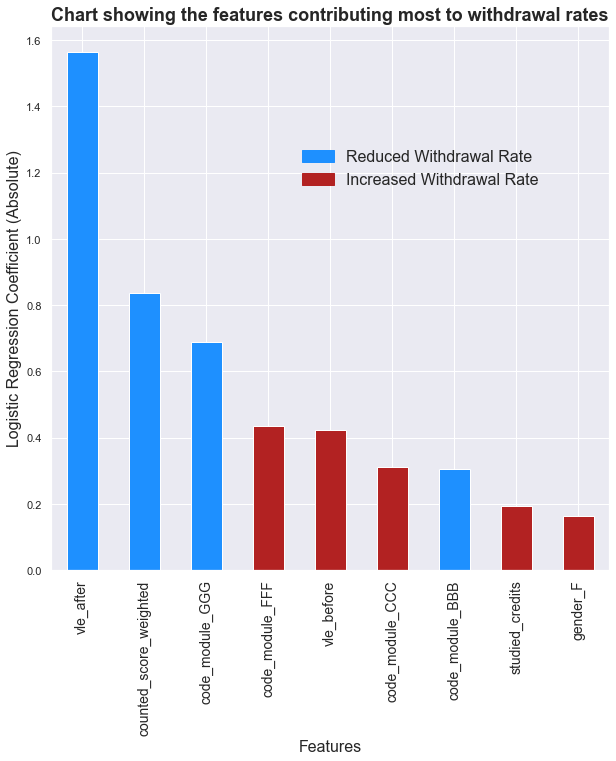

In [136]:
import matplotlib.patches as mpatches
# The coefficients of each feature indicate their relative importance to withdrawal rates
coef_list=logreg_best.coef_.squeeze()
sns.set()
df = {'Features':Xc_train_cols, 'Coefficients':coef_list}
df = pd.DataFrame(df)
df['Abs_Coefficients'] = abs(df['Coefficients'])
# Remove less important features
#df_full = df.copy()
df = df[df['Abs_Coefficients'] > 0.15]
df['posneg'] = np.where(df['Coefficients']<0,'dodgerblue','firebrick')
df = df.sort_values('Abs_Coefficients', ascending=False)
df.plot.bar(x='Features', y='Abs_Coefficients', color=df['posneg'], rot=90, figsize = [10,10])
plt.xlabel('Features', fontsize=16)
plt.ylabel('Logistic Regression Coefficient (Absolute)', fontsize=16)
plt.title('Chart showing the features contributing most to withdrawal rates', fontsize=18, fontweight = 'bold')
leg_neg = mpatches.Patch(color='firebrick', label='Increased Withdrawal Rate')
leg_pos = mpatches.Patch(color='dodgerblue', label='Reduced Withdrawal Rate')
plt.legend(handles=[leg_pos, leg_neg], fontsize=16, loc=1, bbox_to_anchor=(.9, .8))
plt.xticks(fontsize = 14)
plt.show()

#### Statistical Confirmation
To ensure that the variables shown have sufficient statistical significance, a logit model is run separately. Whilst this does not have the regularisation parameters of ElasticNet (which should already account for insignificance of variables by applying low coefficients), it should serve as a confirmation of the findings.
The initial model contained several multicolinear variables and many p-values above the significance level of 0.05. Insignificant variables are removed one at a time to produce the model observed below.

In [98]:
import statsmodels.api as sm
Xc_trainOS_col = pd.DataFrame(Xc_trainOS)
Xc_trainOS_col.columns = Xc_train_cols
#logit=sm.Logit(yc_trainOS,Xc_trainOS_col)
#result=logit.fit()
#print(result.summary2())

cols = ['region_East Midlands Region',
       'region_South Region',
       'region_Wales',
       'region_West Midlands Region', 
       'code_module_BBB', 'code_module_CCC',
       'code_module_EEE', 'code_module_FFF',
       'code_module_GGG', 'highest_education', 'age_band',
       'num_of_prev_attempts', 'studied_credits', 'disability', 'gender_F',
       'vle_before', 'vle_after', 'date_registration', 
       'date_submit_advance', 'counted_score_weighted']
Xc_trainOS_col_rd = Xc_trainOS_col[cols]
logit=sm.Logit(yc_trainOS,Xc_trainOS_col_rd)
result=logit.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.438654
         Iterations 7
                               Results: Logit
Model:                   Logit               Pseudo R-squared:    0.367     
Dependent Variable:      withdrawn           AIC:                 29464.9173
Date:                    2021-03-23 10:28    BIC:                 29633.3272
No. Observations:        33540               Log-Likelihood:      -14712.   
Df Model:                19                  LL-Null:             -23248.   
Df Residuals:            33520               LLR p-value:         0.0000    
Converged:               1.0000              Scale:               1.0000    
No. Iterations:          7.0000                                             
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
regio

We observe that the 20 (significant) variables remaining in the logistic regression model matched up with the top 20 most 'impactful' features of our prediction model.

In [ ]:
# df_full = df_full.sort_values('Abs_Coefficients', ascending=False)

### Outcomes
Aside from now having the ElasticNet model to help with predicting those students who may withdraw, we can see the impact of various features on withdrawals. Looking at the barchart, we can see that a student using the VLE a lot once the course has started, who is achieving good scores in coursework, and/or is on modules GGG or BBB is less likely to withdraw from the course. Conversely, students who are studying modules FFF or CCC, use the VLE more before the course starts (surprisingly), are studying more credits, and/or are female are more likely to withdraw. Some of these findings are intuitive, providing a sense check for the outcomes presented. These results provide useful direction for the university to focus their efforts to reduce withdrawal rates.

### Classification Model Summary
| Statistics\Model | kNN | Tree Ensemble | ElasticNet |
| :-: | :-: | :-: | :-: |
| Training Recall Score | 0.89 | 0.78 | 0.77 |
| Test Recall Score | 0.71 | 0.77 | 0.77 |
| True Positives | 1757 | 1911 | 1898 |
| False Positives | 1291 | 1524 | 878 |
| True Negatives | 4364 | 4131 | 4777 |
| False Negatives | 724 | 570 | 583 |

## Regression
As previously mentioned, prediction of student failures will be made via regression on the average score variable, which is itself based on coursework scores and exam scores where relevant.
Linear models are particularly suited to this task. As logistic regression has only a classification algorithm, the regularised linear models Ridge and Lasso are used. These use L2 and L1 regularisation respectively, which should reduce overfitting compared to a standard linear model.

### Ridge Regression
The Ridge model is built and run below. Whilst this data has been normalised already using PowerTransformer, the Ridge algorithm can also normalise to ensure there is no scale bias present.

In [101]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Specify steps of pipeline
r_steps = [('impute', KNNImputer()),
           ('ridge', Ridge(normalize = True))]
# Construct the pipeline
r_pipe = Pipeline(r_steps)
# Decide ranges of parameters to use
parameters = {
    'impute__n_neighbors': np.arange(3,9),
    'ridge__alpha': np.logspace(-3,2,6)
}
# Set up cross-validation of the pipeline
ridge_cv = RandomizedSearchCV(r_pipe, parameters, cv=5, n_jobs=-2, n_iter=10, random_state = 857)
# Fit Search object to the training data
_ = ridge_cv.fit(Xr_train_trans, yr_train)

# Use model to predict on the test set
yr_pred = ridge_cv.predict(Xr_test_trans)
# Show statistics of modelling
print('R-squared score of ridge regression: {:.2f}'.format(ridge_cv.score(Xr_test_trans,yr_test)))
print('MSE of ridge regression: {:.0f}'.format(mean_squared_error(yr_test,yr_pred)))
print('Ridge regression best hyperparameters: {}'.format(ridge_cv.best_params_))

R-squared score of ridge regression: 0.64
MSE of ridge regression: 366
Ridge regression best hyperparameters: {'ridge__alpha': 0.01, 'impute__n_neighbors': 6}


The Ridge model gave an R-squared of 0.64, suggesting that the model explains 64% of the variance in the scores, with a mean squared error of 366. There is potential for improvement here, so a Lasso model is run.

### Lasso Regression

In [103]:
from sklearn.linear_model import Lasso

# Specify steps of pipeline
r_steps = [('impute', KNNImputer()),
           ('lasso', Lasso(normalize = True, max_iter=10000))]
# Construct the pipeline
r_pipe = Pipeline(r_steps)
# Decide ranges of parameters to use
parameters = {
    'impute__n_neighbors': np.arange(5,10),
    'lasso__alpha': np.logspace(-7,2,10)
}
# Set up cross-validation of the pipeline
lasso_cv = RandomizedSearchCV(r_pipe, parameters, cv=5, n_jobs=-2, n_iter=10, random_state = 271)
# Fit Search object to the training data
_ = lasso_cv.fit(Xr_train_trans, yr_train)

# Use model to predict on the test set
yr_pred = lasso_cv.predict(Xr_test_trans)
# Show statistics of modelling
print('R-squared score of ridge regression: {:.2f}'.format(lasso_cv.score(Xr_test_trans,yr_test)))
print('MSE of ridge regression: {:.0f}'.format(mean_squared_error(yr_test,yr_pred)))
print('Ridge regression best hyperparameters: {}'.format(lasso_cv.best_params_))

R-squared score of ridge regression: 0.64
MSE of ridge regression: 366
Ridge regression best hyperparameters: {'lasso__alpha': 1e-05, 'impute__n_neighbors': 7}


Lasso gave the same R-squared and MSE as Ridge regression, whilst pushing alpha even lower. This indicates that the models are tending towards less regularisation and a more standard linear model.
As we want to examine the coefficients separately, we look to the Ridge regression to discover which features were most important contributors to failure rates.
### Key Feature Identification

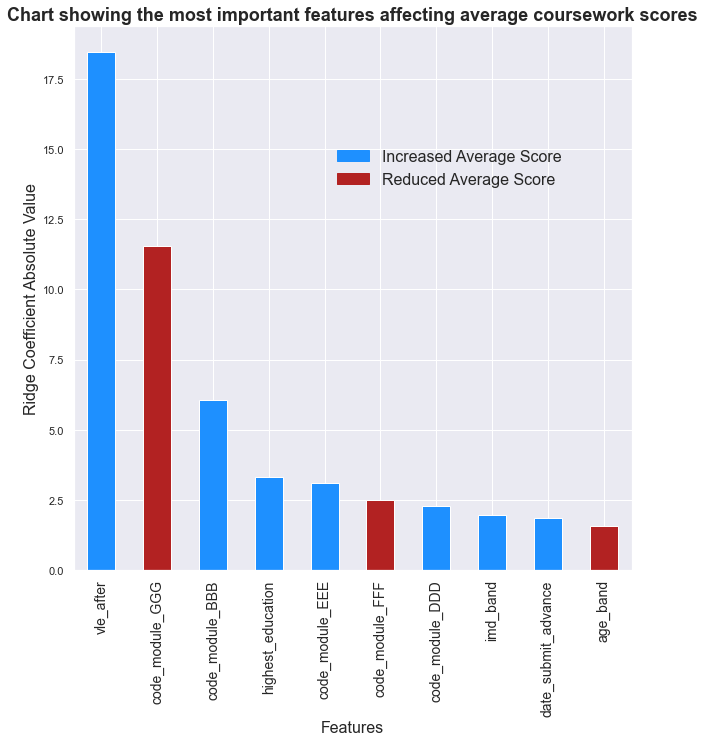

In [105]:
# The optimal Ridge model is run
imputer = KNNImputer(n_neighbors=6)
Xr_train_imp = imputer.fit_transform(Xr_train_trans)
Xr_train_cols = Xr_train.columns

ridge_best = Ridge(normalize = True, alpha = 0.01)
_ = ridge_best.fit(Xr_train_imp, yr_train)

# The coefficients of each feature indicate their relative importance to withdrawal rates
coef_list=ridge_best.coef_.squeeze()
sns.set()
df = {'Features':Xr_train_cols, 'Coefficients':coef_list}
df = pd.DataFrame(df)
df['Abs_Coefficients'] = abs(df['Coefficients'])
# Remove less important features
df = df[df['Abs_Coefficients'] > 1.5]
df['posneg'] = np.where(df['Coefficients']>0,'dodgerblue','firebrick')
df = df.sort_values('Abs_Coefficients', ascending=False)
df.plot.bar(x='Features', y='Abs_Coefficients', color=df['posneg'], rot=90, figsize = [10,10])
plt.xlabel('Features', fontsize=16)
plt.ylabel('Ridge Coefficient Absolute Value', fontsize=16)
plt.title('Chart showing the most important features affecting average coursework scores', fontsize=18, fontweight = 'bold')
leg_neg = mpatches.Patch(color='firebrick', label='Reduced Average Score')
leg_pos = mpatches.Patch(color='dodgerblue', label='Increased Average Score')
plt.legend(handles=[leg_pos, leg_neg], fontsize=16, loc=1, bbox_to_anchor=(.9, .8))
plt.xticks(fontsize = 14)
plt.show()

### Outcomes
The graph shows the factors most important in determining a student's average score. This directly relates to failure rates, as, by the Open University rules, an average score below 40% is a fail (outside of extenuating circumstances). It can be observed that students that engage more with the VLE during the module, with a higher level of education, from a less deprived background, who submit coursework ahead of deadlines, or who study modules BBB/EEE/DDD are more likely to achieve a higher score, and therefore less likely to fail. Conversely, older students or those on modules GGG or FFF are more likely to fail by virtue of a lower score. This provides the University with clear areas to target additional resources and advice for students. Most specifically, they can investigate why GGG may be marked lower than other modules, encourage students to engage more with the VLE, and provide more support for older students.

# Conclusion
Overall, several target areas have been identified during this work for The Open University to dedicate more resources and support. The primary indicator of students failing or withdrawing is the amount of engagement with the VLE during the course, with more use leading to reduced dropouts and failures. Students with lower coursework scores, females, and those studying more credits are more likely to withdraw, so the university can target these groups with more support as appropriate. Additionally, those with lower existing education levels, who are older or from more deprived backgrounds are more likely to fail. This is important to again dedicate more resources to these groups, as reduced failure rates will likely mean future additional study and more business for the university.

## Limitations
The models developed can be used directly on future groups of students to predict their withdrawal and failure rates. However, there are some limitations to the modelling performed. The test data was split from the main dataset at random, and both sets were transformed independently. This was fine in this scenario as there was a large dataset involved, and the test set was randomly sampled. However, running the same processes here on a new sample of students, particularly if a small sample is used, would potentially create a noticeably different transform function on the sample. To avoid this, the transform function from the PowerTransform step should be hard-coded into the process for future use to ensure best predictions.

Another issue is around limits used on module length. The EDA showed a clear grouping of modules into two categories. A cutoff was decided at 250 days as this was roughly the midpoint between these groups. However, modules of different lengths outside of this dataset could affect this grouping, and could feasibly straddle this somewhat arbitrary cutoff point. If this does happen, then it may make sense in future iterations of these models to keep module length as continuous data.

The n-neighbors was imputed in each model, with no consensus on the 'right' value for this, suggesting this hyperparameter may be artificially boosting the scores of the models. Also, for the classifier process, SMOTE was used to generate a larger sample of the positive class ('Withdraw'). This could be an issue, particularly if the students that withdrew in our sample were not typical of this class, i.e. not representative of students who withdraw generally. In this way, through oversampling, a small bias in the data may have been amplified, making it difficult to generalise this model. Ultimately, we do not know how this data was collected and whether we are using a fair sample that can be generalised. Not only that, but the data is 7 years old, so may not still be relevant to use on future modules and students.

Additionally, some features of the data may have been overlooked or masked in the feature engineering that was used. For example, the vle.csv dataset was not used at all, but may have held useful information. Also, missing values may have been imputed incorrectly, and some records were removed for containing unusual-looking data, but this may have been informative. Not only this, but during EDA it was noticed that there were some students with av_score <40% who still passed - this was assumed to be due to exceptional circumstances, but could mean poor quality data or misinterpretation of these instances.

## Further analysis
Further analysis could look at alternative models, such as support vector machine or neural networks, to try to improve to outcomes of the test data. It would be useful to also use more data in the analysis to improve the reliability of any conclusions drawn, particularly if the data was more up to date. In this assignment, the primarily important feature in both classification and regression tasks was related to the student's use of the VLE. This was a 10million+ row dataset, from which ultimately only 2 variables were engineered - this data could be further explored to generate more variables to provide a better understanding of how a student's use of the VLE influenced scores/failures and withdrawals.

Ultimately, the models are only as good as the data and processes utilised. As everyone's approach is different and these models are unique to myself, it may be beneficial for the university to use several models from different data scientists from which to draw conclusions.